In [1]:
import pandas as pd
import numpy as np

In [2]:
features_regional = np.load('features_regional.npy')
features_shape = np.load('features_shape.npy')
features_stats = np.load('features_stats.npy')
features_histogram = np.load('features_histogram.npy')
features_texture = np.load('features_texture.npy')

features = np.concatenate((features_regional, features_shape,
                           features_stats,features_histogram,np.nan_to_num(features_texture)),axis=1)
features.shape

(1472, 327)

In [3]:
from sklearn import preprocessing

labels = pd.read_csv('../data/ATR_GT_Training.csv', header=None)

In [4]:
X = features[:1005]
y = labels.iloc[:1005, 1]
y_bin = (y!=0).astype(int)

In [5]:
X_scaled = preprocessing.scale(X)

In [6]:
classifiers=[]

In [7]:
from sklearn import svm
classifiers.append(['default svm', svm.SVC()])

In [8]:
from sklearn.linear_model import LogisticRegression
classifiers.append(['logistic reg', LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')])

In [9]:
from sklearn.ensemble import AdaBoostClassifier
classifiers.append(['adaboost', AdaBoostClassifier(n_estimators=100)])

In [10]:
from sklearn.neighbors import KNeighborsClassifier
classifiers.append(['knn 3', KNeighborsClassifier(n_neighbors=3)])

In [11]:
# Use a Multi-layer Perceptron classifier . It trains via backpropagation 
from sklearn.neural_network import MLPClassifier
classifiers.append(['NN', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)])

In [19]:
def getAcc(y_true,y_pred):
    return accuracy_score(y_true,y_pred)

def getPD(y_true,y_pred):
    '''get percent detected (# targets detected / # targets)'''
    return recall_score(y_true,y_pred)

def getPFA(y_true,y_pred):
    '''get percent false alarms (# false alarms / # non-targets)'''
    return 1-accuracy_score(1-y_true,1-y_pred)

In [12]:
from sklearn.model_selection import cross_val_score
def cross_validate(classifier,X,y,name,cv_=5):
    scores = cross_val_score(classifier, X, y, cv=cv_)
    print('Clf: {}\nAccuracy: {:0.2f} +/- {:0.2f}'.format(name, scores.mean(), scores.std() * 2))

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score
def print_results(X, y, clf, strr):
    kf = KFold(n_splits=5)
    PD,PD1,PD2,PD3 = [],[],[],[]
    PFA = []
    acc=[]

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        predict = clf.fit(X_train, y_train!=0).predict(X_test)

        acc.append(getAcc(y_test!=0, predict))
        PD.append(getPD(y_test!=0,   predict))
        PD1.append(getPD(y_test==1,  predict))
        PD2.append(getPD(y_test==2,  predict))
        PD3.append(getPD(y_test==3,  predict))
        PFA.append(getPFA(y_test!=0, predict))
    
    print(strr)
    print('accuracy               ',np.mean(acc),'\n')
    print('percent detected       ',np.mean(PD),'\n')
    print('percent false alarm    ',np.mean(PFA),'\n')
    print('percent detected saline',np.mean(PD1))
    print('percent detected rubber',np.mean(PD2))
    print('percent detected clay  ',np.mean(PD3))
    print('\n\n')
    return np.mean(PD)

In [14]:
import warnings
warnings.filterwarnings('ignore')
for classifier_name, classifier in classifiers:
    cross_validate(classifier,X_scaled,y_bin,classifier_name)

Clf: default svm
Accuracy: 0.77 +/- 0.07
Clf: logistic reg
Accuracy: 0.77 +/- 0.07
Clf: adaboost
Accuracy: 0.83 +/- 0.05
Clf: knn 3
Accuracy: 0.75 +/- 0.05
Clf: NN
Accuracy: 0.76 +/- 0.05


In [15]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=classifiers, voting='hard')
cross_validate(eclf,X_scaled,y_bin,'ensemble')

Clf: ensemble
Accuracy: 0.81 +/- 0.08


ensemble
accuracy                0.8119402985074625 

percent detected        0.619568315784071 

percent false alarm     0.1880597014925373 

percent detected saline 0.561452380952381
percent detected rubber 0.6684983239737059
percent detected clay   0.6447191697191698



ensemble
accuracy                0.8238805970149252 

percent detected        0.5487241181516845 

percent false alarm     0.1761194029850746 

percent detected saline 0.4373095238095238
percent detected rubber 0.6474271908057986
percent detected clay   0.5630982905982906



ensemble
accuracy                0.8447761194029851 

percent detected        0.6198511682681813 

percent false alarm     0.15522388059701492 

percent detected saline 0.5773095238095238
percent detected rubber 0.6293924948848548
percent detected clay   0.6618681318681319



ensemble
accuracy                0.853731343283582 

percent detected        0.6269835629711975 

percent false alarm     0.14626865671641792 

percent detected saline 0.480

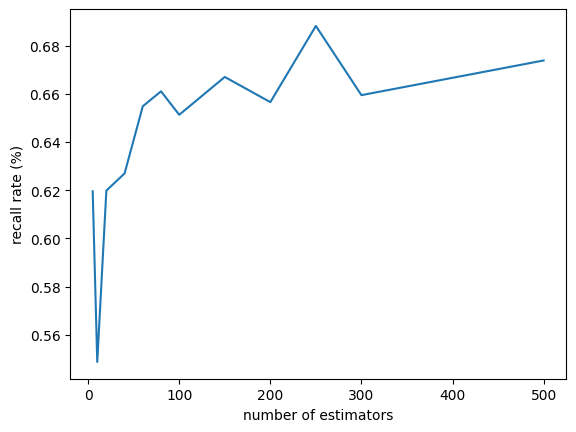

In [26]:
e = [5, 10, 20, 40, 60, 80, 100, 150, 200, 250, 300, 500]
from sklearn.ensemble import RandomForestClassifier
p = []
for ee in e:
    p.append(print_results(X, y, RandomForestClassifier(n_estimators=ee, max_depth=None, min_samples_split=2), 'ensemble'))

import matplotlib.pyplot as plt
plt.plot(e,p)
plt.xlabel('number of estimators')
plt.ylabel('recall rate (%)')
plt.savefig('estimators.png')
plt.show()

ensemble
accuracy                0.7701492537313432 

percent detected        0.26736401225261686 

percent false alarm     0.2298507462686567 

percent detected saline 0.14097619047619048
percent detected rubber 0.40077380175003263
percent detected clay   0.26224664224664224



ensemble
accuracy                0.7800995024875621 

percent detected        0.3420994478877434 

percent false alarm     0.21990049751243781 

percent detected saline 0.1716904761904762
percent detected rubber 0.4250054416438118
percent detected clay   0.47021978021978017



ensemble
accuracy                0.8099502487562189 

percent detected        0.45454529559635615 

percent false alarm     0.1900497512437811 

percent detected saline 0.30788095238095237
percent detected rubber 0.4977754560097514
percent detected clay   0.6246123321123321



ensemble
accuracy                0.834825870646766 

percent detected        0.5761954959055482 

percent false alarm     0.1651741293532338 

percent detected sali

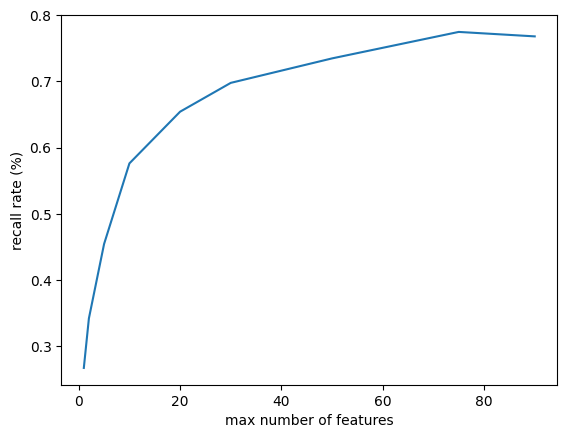

In [23]:
ee = [1, 2, 5, 10, 20, 30, 50, 75, 90]
from sklearn.ensemble import RandomForestClassifier
pp = []
for eee in ee:
    pp.append(print_results(X, y, RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, max_features=eee), 'ensemble'))

import matplotlib.pyplot as plt
plt.plot(ee,pp)
plt.xlabel('max number of features')
plt.ylabel('recall rate (%)')
plt.savefig('features.png')
plt.show()

In [27]:
clff = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, max_features=100)
print_results(X, y, clff, 'Random Forest')

hi
accuracy                0.8686567164179106 

percent detected        0.7605101271341543 

percent false alarm     0.13134328358208952 

percent detected saline 0.728547619047619
percent detected rubber 0.716782029515476
percent detected clay   0.8717246642246643





0.7605101271341543

In [28]:
clff = clff.fit(X, y)
pred = clff.predict(features[1005:])
filenames = labels.iloc[1005:, 0]
pred_df = {'file': filenames, 'prediction': pred}
pd.DataFrame(pred_df).to_csv('predictions2.csv')